In [55]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [56]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [57]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [58]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [59]:
tf.keras.backend.clear_session()

In [60]:
subject = 'Goiás - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [61]:
data = pd.read_csv('2003_mo_model_input_GO.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Goiás - Produção de Cimento (t),Goiás - Consumo de Cimento (t),Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,56.459960,97.447,0.706514,0.745293,2.213042,931.959546,1486.445398,23.971618,18.270239,73.649051,1.213018,0.775614,10601.325200,3.935260e+06,0.260097,9.371822e+07,5.518325e+06,14.031270,8.418248e+07,8.179785,0.767692,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,56.789152,97.256,0.706866,0.745405,2.021028,932.363097,1483.971093,23.534386,17.704093,73.006649,1.243670,0.775902,10688.670969,3.962330e+06,0.258964,9.383590e+07,5.523290e+06,14.034476,8.422082e+07,8.174086,0.767405,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,57.140263,101.442,0.707217,0.745517,1.823148,932.798217,1450.427392,22.934067,16.667652,71.378895,1.262206,0.776190,10770.309117,3.989401e+06,0.257352,9.395358e+07,5.528254e+06,14.037682,8.425916e+07,8.168386,0.767117,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,57.649192,98.217,0.707569,0.745629,1.756117,933.532125,1458.264605,22.346879,15.045930,67.632317,1.355424,0.776478,10847.723760,4.016472e+06,0.255929,9.407126e+07,5.533219e+06,14.040888,8.429750e+07,8.162687,0.766830,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,58.213295,112.540,0.707920,0.745741,1.331530,934.018275,1466.468143,21.987268,13.454185,63.216002,1.434779,0.776766,10930.821691,4.043542e+06,0.254109,9.418894e+07,5.538184e+06,14.044093,8.433584e+07,8.156988,0.766543,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36860.347731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36833.247910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36770.607054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36688.936705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


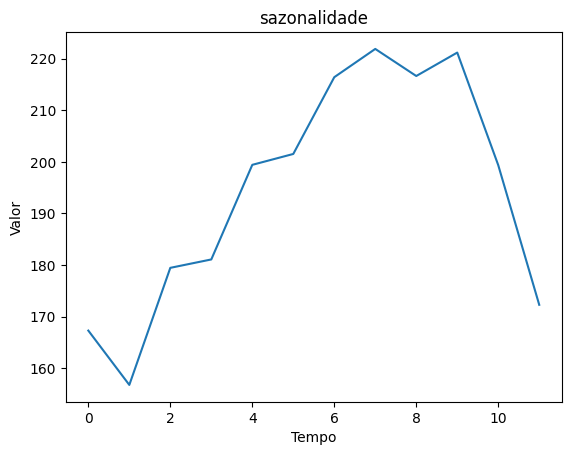

,sazonalidade
sazonalidade,
0,167.283259
1,156.749393
2,179.448007
3,181.076702
4,199.417905
5,201.527477
6,216.411127
7,221.891678
8,216.641355


In [62]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [63]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Goiás - Produção de Cimento (t),Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Goiás - Consumo de Cimento (t)
0,2003-1,56.459960,0.706514,0.745293,2.213042,931.959546,1486.445398,23.971618,18.270239,73.649051,1.213018,0.775614,10601.325200,3.935260e+06,0.260097,9.371822e+07,5.518325e+06,14.031270,8.418248e+07,8.179785,0.767692,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,167.283259,97.447
1,2003-2,56.789152,0.706866,0.745405,2.021028,932.363097,1483.971093,23.534386,17.704093,73.006649,1.243670,0.775902,10688.670969,3.962330e+06,0.258964,9.383590e+07,5.523290e+06,14.034476,8.422082e+07,8.174086,0.767405,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,156.749393,97.256
2,2003-3,57.140263,0.707217,0.745517,1.823148,932.798217,1450.427392,22.934067,16.667652,71.378895,1.262206,0.776190,10770.309117,3.989401e+06,0.257352,9.395358e+07,5.528254e+06,14.037682,8.425916e+07,8.168386,0.767117,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,179.448007,101.442
3,2003-4,57.649192,0.707569,0.745629,1.756117,933.532125,1458.264605,22.346879,15.045930,67.632317,1.355424,0.776478,10847.723760,4.016472e+06,0.255929,9.407126e+07,5.533219e+06,14.040888,8.429750e+07,8.162687,0.766830,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,181.076702,98.217
4,2003-5,58.213295,0.707920,0.745741,1.331530,934.018275,1466.468143,21.987268,13.454185,63.216002,1.434779,0.776766,10930.821691,4.043542e+06,0.254109,9.418894e+07,5.538184e+06,14.044093,8.433584e+07,8.156988,0.766543,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,199.417905,112.540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36860.347731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,199.417905,NaN
257,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36833.247910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.527477,NaN
258,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36770.607054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.411127,NaN
259,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36688.936705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.891678,NaN


In [64]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      121.831
1      115.210
2      122.721
3      130.262
4      139.268
        ...   
256        NaN
257        NaN
258        NaN
259        NaN
260        NaN
Name: Goiás - Consumo de Cimento (t), Length: 261, dtype: float64

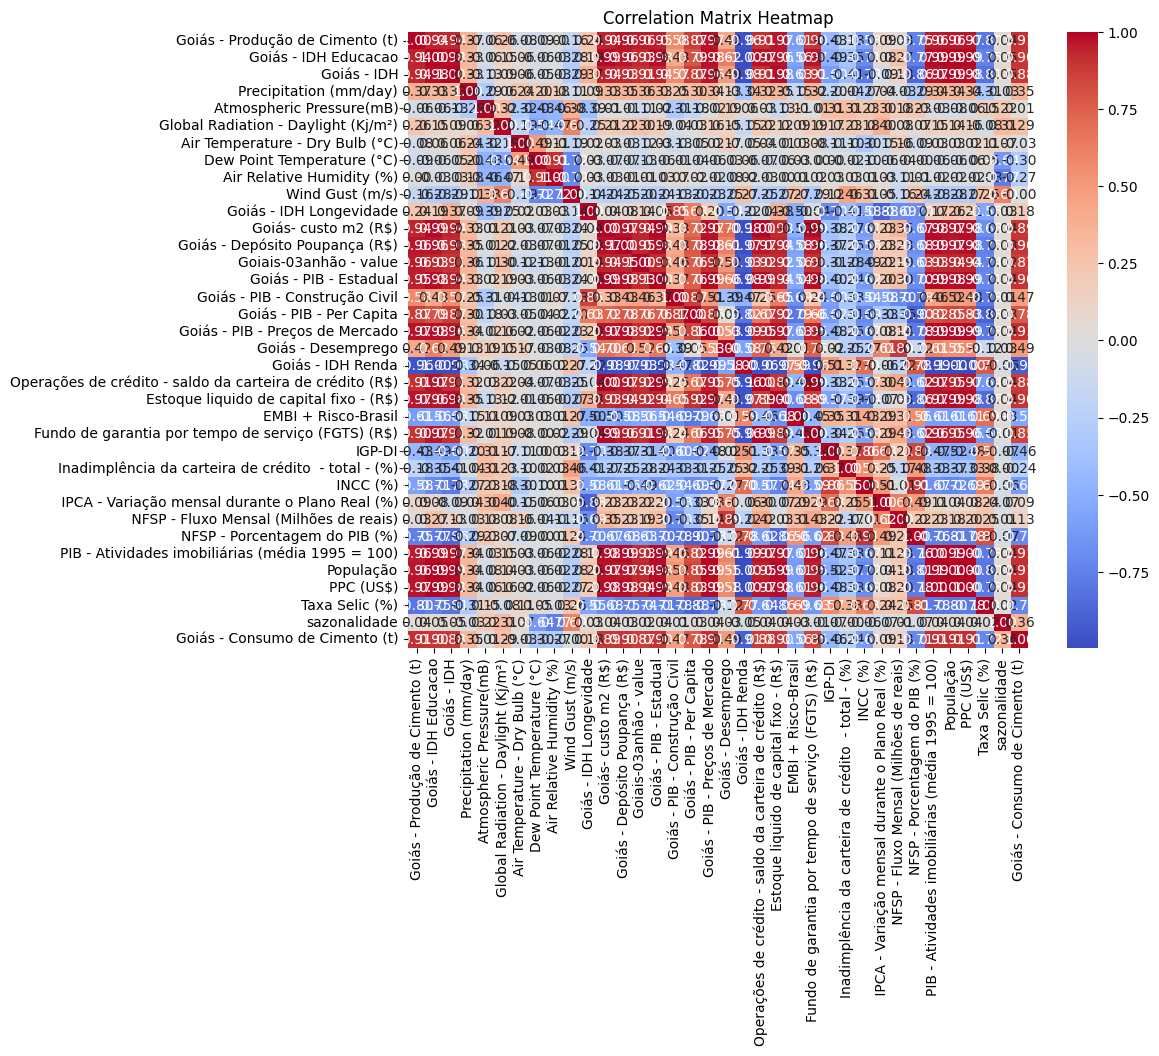

In [65]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [67]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Goiás - Produção de Cimento (t),5.000745e+03
1,Goiás - IDH Educacao,2.339938e+06
2,Goiás - IDH,6.332454e+04
3,Precipitation (mm/day),3.410729e+00
4,Atmospheric Pressure(mB),1.764240e+01
5,Global Radiation - Daylight (Kj/m²),9.111631e+00
6,Air Temperature - Dry Bulb (°C),1.216840e+02
7,Dew Point Temperature (°C),9.581737e+02
8,Air Relative Humidity (%),8.659555e+02
9,Wind Gust (m/s),3.510631e+01


In [68]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 0


,Goiás - Produção de Cimento (t),Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,56.459960,0.706514,0.745293,2.213042,931.959546,1486.445398,23.971618,18.270239,73.649051,1.213018,0.775614,10601.325200,3.935260e+06,0.260097,9.371822e+07,5.518325e+06,14.031270,8.418248e+07,8.179785,0.767692,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,167.283259
1,56.789152,0.706866,0.745405,2.021028,932.363097,1483.971093,23.534386,17.704093,73.006649,1.243670,0.775902,10688.670969,3.962330e+06,0.258964,9.383590e+07,5.523290e+06,14.034476,8.422082e+07,8.174086,0.767405,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,156.749393
2,57.140263,0.707217,0.745517,1.823148,932.798217,1450.427392,22.934067,16.667652,71.378895,1.262206,0.776190,10770.309117,3.989401e+06,0.257352,9.395358e+07,5.528254e+06,14.037682,8.425916e+07,8.168386,0.767117,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,179.448007
3,57.649192,0.707569,0.745629,1.756117,933.532125,1458.264605,22.346879,15.045930,67.632317,1.355424,0.776478,10847.723760,4.016472e+06,0.255929,9.407126e+07,5.533219e+06,14.040888,8.429750e+07,8.162687,0.766830,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,181.076702
4,58.213295,0.707920,0.745741,1.331530,934.018275,1466.468143,21.987268,13.454185,63.216002,1.434779,0.776766,10930.821691,4.043542e+06,0.254109,9.418894e+07,5.538184e+06,14.044093,8.433584e+07,8.156988,0.766543,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,199.417905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,116.893660,0.754007,0.755030,2.295059,932.617910,1473.163208,24.834125,13.660415,55.943593,1.335753,0.781851,22612.078761,1.022494e+07,0.363623,1.118534e+08,5.596784e+06,14.193533,8.783157e+07,9.386642,0.732090,3.143856e+06,7.824899e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,1.969730e+08,390.589413,1.078474,221.891678
152,117.224513,0.754939,0.755279,2.260187,932.087819,1469.599470,25.403315,14.784935,57.886375,1.294746,0.782286,22698.982762,1.018590e+07,0.364092,1.119022e+08,5.592207e+06,14.191662,8.782916e+07,9.385003,0.731396,3.159665e+06,7.823710e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,1.970500e+08,391.798431,0.962516,216.641355
153,117.667660,0.755871,0.755528,2.248195,931.618199,1420.112459,25.351006,16.083863,62.350671,1.270932,0.782721,22798.284775,1.014685e+07,0.364153,1.119511e+08,5.587630e+06,14.189792,8.782674e+07,9.383365,0.730701,3.177292e+06,7.822521e+06,356.198303,9.630300e+06,0.447600,3

In [69]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,-1.829233,-2.226732,0.286823,-0.093351,0.952808,0.424787,1.117179,1.182339,-0.597347,-2.555945,-1.463549,-1.377223,-0.740349,-1.579039,-2.245712,-2.354537,-1.886512,-0.144101,1.861583,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617
1,-1.802651,-2.183416,-0.064035,0.214072,0.925984,-0.112916,0.850808,1.078503,-0.404905,-2.464705,-1.440135,-1.366530,-0.762181,-1.558862,-2.183774,-2.308411,-1.854319,-0.155703,1.833670,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013
2,-1.776069,-2.140101,-0.425609,0.545545,0.562336,-0.851181,0.363163,0.815398,-0.288533,-2.373466,-1.418250,-1.355837,-0.793203,-1.538686,-2.121835,-2.262286,-1.822127,-0.167304,1.805756,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457
3,-1.749487,-2.096785,-0.548091,1.104632,0.647299,-1.573297,-0.399856,0.209812,0.296700,-2.282226,-1.397498,-1.345144,-0.820607,-1.518509,-2.059897,-2.216161,-1.789934,-0.178906,1.777843,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128
4,-1.722905,-2.053470,-1.323916,1.474979,0.736234,-2.015543,-1.148771,-0.504028,0.794905,-2.190986,-1.375222,-1.334452,-0.855647,-1.498332,-1.997959,-2.170036,-1.757741,-0.190507,1.749929,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.761135,1.542223,0.436688,0.408188,0.808815,1.485487,-1.051740,-1.679518,0.173201,-0.579538,1.756160,1.107178,1.252852,1.530343,-1.266882,-0.019862,1.177469,2.312612,-1.598243,1.823582,0.951535,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.382734,1.398025,0.209123
152,1.831610,1.638675,0.372968,0.004367,0.770181,2.185471,-0.522654,-1.365493,-0.084244,-0.441592,1.779456,1.091756,1.261880,1.538722,-1.323978,-0.046780,1.175441,2.309277,-1.665768,1.841017,0.944143,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.395760,1.415152,-0.182135
153,1.902086,1.735127,0.351057,-0.353388,0.233691,2.121142,0.088490,-0.643897,-0.233753,-0.303647,1.806076,1.076334,1.263045,1.547101,-1.381074,-0.073698,1.173412,2.305942,-1.733293,1.860456,0.936751,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.408786,1.432633,0.413308
154,1.972561,1.831579,0.365800,-0.436584,0.128888,1.827839,0.642934,0.043075,-0.567950,-0.165702,1.833202,1.060912,1.263890,1.555480,-1.438170,-0.100617,1.171383,2.302606,-1.800818,1.876950,0.929358,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.421813,1.450965,0.074029


In [70]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,-1.829233,-2.226732,0.286823,-0.093351,0.952808,0.424787,1.117179,1.182339,-0.597347,-2.555945,-1.463549,-1.377223,-0.740349,-1.579039,-2.245712,-2.354537,-1.886512,-0.144101,1.861583,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617
1,-1.802651,-2.183416,-0.064035,0.214072,0.925984,-0.112916,0.850808,1.078503,-0.404905,-2.464705,-1.440135,-1.366530,-0.762181,-1.558862,-2.183774,-2.308411,-1.854319,-0.155703,1.833670,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013
2,-1.776069,-2.140101,-0.425609,0.545545,0.562336,-0.851181,0.363163,0.815398,-0.288533,-2.373466,-1.418250,-1.355837,-0.793203,-1.538686,-2.121835,-2.262286,-1.822127,-0.167304,1.805756,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457
3,-1.749487,-2.096785,-0.548091,1.104632,0.647299,-1.573297,-0.399856,0.209812,0.296700,-2.282226,-1.397498,-1.345144,-0.820607,-1.518509,-2.059897,-2.216161,-1.789934,-0.178906,1.777843,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128
4,-1.722905,-2.053470,-1.323916,1.474979,0.736234,-2.015543,-1.148771,-0.504028,0.794905,-2.190986,-1.375222,-1.334452,-0.855647,-1.498332,-1.997959,-2.170036,-1.757741,-0.190507,1.749929,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.208488,0.913144,0.762891,0.616351,0.889843,0.620292,-1.162585,-1.514342,0.171530,-1.197807,1.428785,1.367469,1.131607,1.406174,-0.435110,0.358405,1.202400,2.011654,-1.116080,1.517172,1.018624,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.222749,1.245801,-0.282621
140,1.220351,0.903927,1.302729,0.140640,0.643805,1.024228,-0.582028,-1.016938,-0.122397,-1.267276,1.455525,1.337002,1.143264,1.419277,-0.521530,0.320437,1.200254,2.076515,-1.117978,1.549848,1.015555,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.236509,1.254608,-0.612121
141,1.232215,0.894710,0.523309,-0.074479,0.871286,1.264159,-0.232178,-0.720932,-0.289431,-1.336746,1.482792,1.306534,1.154958,1.432380,-0.607949,0.282470,1.198108,2.141376,-1.119875,1.588878,1.012487,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.250269,1.263636,-0.137902
142,1.244078,0.885492,-0.004427,-0.261399,0.670015,1.031454,0.320988,-0.030988,-0.634432,-1.406216,1.510845,1.276066,1.166716,1.445482,-0.694369,0.244502,1.195962,2.206237,-1.121773,1.625721,1.009418,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.264029,1.272935,-0.332143


In [71]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      121.831000
1      115.210000
2      122.721000
3      130.262000
4      139.268000
          ...    
139    221.818942
140    215.527652
141    217.558892
142    199.182304
143    182.381000
Name: Goiás - Consumo de Cimento (t), Length: 144, dtype: float64

In [72]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [73]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 33)

In [74]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
108,0.657562,0.649465,0.368323,-0.514589,0.332465,-0.285126,0.880226,1.270644,-0.752533,0.554530,0.680625,0.717769,0.826205,0.797378,0.959384,1.357936,1.000382,-0.945110,-0.711392,0.595959,0.890825,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.754385,0.812014,-1.082183
109,0.679301,0.672916,0.936846,-0.194784,0.469436,-0.520899,0.775258,1.220819,-0.637701,0.507057,0.703389,0.770983,0.840065,0.821288,0.941954,1.324574,1.012907,-0.842705,-0.748487,0.621380,0.900214,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.770574,0.831569,-1.036767
110,0.701040,0.696367,1.483855,0.243345,0.146816,-0.836803,0.627882,1.162414,-0.688867,0.459584,0.725877,0.824196,0.850033,0.845198,0.924524,1.291212,1.025433,-0.740299,-0.785582,0.652999,0.909602,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.786763,0.850791,-0.752482
111,0.722780,0.719818,0.978418,0.719428,0.104038,-1.428006,0.155768,0.847412,-0.523305,0.412111,0.748506,0.877410,0.859798,0.869108,0.907094,1.257850,1.037958,-0.637894,-0.822678,0.685630,0.918990,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.802953,0.868783,-1.088413
112,0.744519,0.743268,1.240415,1.380637,0.258650,-1.855039,-0.605472,0.101726,0.705722,0.364639,0.771194,0.930624,0.866972,0.893018,0.889663,1.224487,1.050484,-0.535489,-0.859773,0.717515,0.928378,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.819142,0.886720,-1.508135
113,0.766258,0.766719,1.435488,1.572879,0.615028,-1.347958,-1.106809,-0.658441,1.032748,0.317166,0.793952,0.983837,0.873968,0.916928,0.872233,1.191125,1.063009,-0.433083,-0.896868,0.747579,0.937766,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.835331,0.905151,-1.474280
114,0.787997,0.790170,1.640795,1.320941,1.178904,-0.612744,-1.439728,-1.337572,1.608759,0.269693,0.816412,1.037051,0.884720,0.940838,0.854803,1.157763,1.075535,-0.330678,-0.933964,0.775262,0.947155,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.851520,0.923702,-1.463452
115,0.809736,0.813621,2.031965,0.780001,1.131171,0.088753,-1.116720,-1.255098,1.972926,0.222220,0.842339,1.090265,0.895397,0.964748,0.837372,1.124401,1.088060,-0.228272,-0.971059,0.805205,0.956543,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.867709,0.942382,-1.236037
116,0.831475,0.837071,2.269900,0.025621,1.093672,0.806214,-0.493691,-0.806960,1.217717,0.174747,0.863357,1.143478,0.905291,0.988659,0.819942,1.091038,1.100586,-0.125867,-1.008154,0.836796,0.965931,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.883899,0.960385,-0.935721
117,0.853214,0.860522,2.305437,-0.536986,0.644359,0.828830,0.170196,-0.057677,0.983422,0.127275,0.883418,1.196692,0.913822,1.012569,0.802512,1.057676,1.113111,-0.023462,-1.045250,0.876422,0.975319,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.9000

In [75]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 33)

In [76]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [77]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [78]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [79]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3288859448, 1893083366, 4242069026, 1749551230, 1478797725, 690239260, 449531743, 689200809, 3873810960, 4060118757]


Step: 0 ___________________________________________
val_loss: 405.9114074707031
winner_seed: 3288859448


Step: 1 ___________________________________________
val_loss: 451.4093017578125


Step: 2 ___________________________________________
val_loss: 288.05731201171875
winner_seed: 4242069026


Step: 3 ___________________________________________
val_loss: 524.568603515625


Step: 4 ___________________________________________
val_loss: 896.1832275390625


Step: 5 ___________________________________________
val_loss: 621.0482177734375


Step: 6 ___________________________________________
val_loss: 662.3795776367188


Step: 7 ___________________________________________
val_loss: 754.0370483398438


Step: 8 ___________________________________________
val_loss: 289.0033264160156


Step: 9 ___________________________________________
val_loss: 374.0523681640625


final_seed: 

In [80]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 129ms/step - loss: 51287.7695 - val_loss: 2997.0273
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 5749.0801 - val_loss: 2213.8032
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 7823.7075 - val_loss: 1026.8420
Epoch 4/10000
4/4 [==============================] - 0s 10ms/step - loss: 1718.3263 - val_loss: 391.9082
Epoch 5/10000
4/4 [==============================] - 0s 10ms/step - loss: 2230.3022 - val_loss: 1358.1017
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 1509.9507 - val_loss: 1439.8099
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 1453.6965 - val_loss: 1174.1144
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 1357.6226 - val_loss: 3174.4768
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 1341.4979 - val_loss: 2367.5142
Epoch 10/10000
4/4 [===========================

4/4 [==============================] - 0s 10ms/step - loss: 506.0776 - val_loss: 3144.2666
Epoch 79/10000
4/4 [==============================] - 0s 10ms/step - loss: 426.6085 - val_loss: 3491.7195
Epoch 80/10000
4/4 [==============================] - 0s 10ms/step - loss: 432.5013 - val_loss: 1659.1676
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 720.3909 - val_loss: 1708.0917
Epoch 82/10000
4/4 [==============================] - 0s 10ms/step - loss: 626.8499 - val_loss: 4539.5435
Epoch 83/10000
4/4 [==============================] - 0s 11ms/step - loss: 436.2346 - val_loss: 5369.5020
Epoch 84/10000
4/4 [==============================] - 0s 10ms/step - loss: 712.0670 - val_loss: 4226.1992
Epoch 85/10000
4/4 [==============================] - 0s 10ms/step - loss: 540.9743 - val_loss: 4584.9795
Epoch 86/10000
4/4 [==============================] - 0s 10ms/step - loss: 466.5401 - val_loss: 1914.1163
Epoch 87/10000
4/4 [==============================] - 0s 10ms

Epoch 155/10000
4/4 [==============================] - 0s 10ms/step - loss: 394.4768 - val_loss: 457.9965
Epoch 156/10000
4/4 [==============================] - 0s 10ms/step - loss: 1349.4711 - val_loss: 1176.0253
Epoch 157/10000
4/4 [==============================] - 0s 11ms/step - loss: 515.7337 - val_loss: 3065.3757
Epoch 158/10000
4/4 [==============================] - 0s 10ms/step - loss: 564.0338 - val_loss: 1501.1676
Epoch 159/10000
4/4 [==============================] - 0s 10ms/step - loss: 399.4469 - val_loss: 2128.5469
Epoch 160/10000
4/4 [==============================] - 0s 10ms/step - loss: 403.4196 - val_loss: 1493.0255
Epoch 161/10000
4/4 [==============================] - 0s 10ms/step - loss: 437.4712 - val_loss: 1430.1530
Epoch 162/10000
4/4 [==============================] - 0s 10ms/step - loss: 438.3586 - val_loss: 2472.0044
Epoch 163/10000
4/4 [==============================] - 0s 10ms/step - loss: 396.3679 - val_loss: 2252.0920
Epoch 164/10000
4/4 [================

4/4 [==============================] - 0s 10ms/step - loss: 720.7079 - val_loss: 1707.9982
Epoch 232/10000
4/4 [==============================] - 0s 10ms/step - loss: 669.1672 - val_loss: 1270.7250
Epoch 233/10000
4/4 [==============================] - 0s 9ms/step - loss: 636.2012 - val_loss: 1701.6874
Epoch 234/10000
4/4 [==============================] - 0s 9ms/step - loss: 553.4951 - val_loss: 3520.9712
Epoch 235/10000
4/4 [==============================] - 0s 10ms/step - loss: 522.6410 - val_loss: 4615.5142
Epoch 236/10000
4/4 [==============================] - 0s 10ms/step - loss: 517.6983 - val_loss: 2569.1807
Epoch 237/10000
4/4 [==============================] - 0s 11ms/step - loss: 561.2666 - val_loss: 2604.8843
Epoch 238/10000
4/4 [==============================] - 0s 11ms/step - loss: 451.1810 - val_loss: 2262.7725
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 439.6902 - val_loss: 2234.0293
Epoch 240/10000
4/4 [==============================] - 

Epoch 308/10000
4/4 [==============================] - 0s 10ms/step - loss: 406.6178 - val_loss: 1555.6809
Epoch 309/10000
4/4 [==============================] - 0s 10ms/step - loss: 348.9553 - val_loss: 854.1160
Epoch 310/10000
4/4 [==============================] - 0s 10ms/step - loss: 472.5460 - val_loss: 1269.5342
Epoch 311/10000
4/4 [==============================] - 0s 11ms/step - loss: 376.7561 - val_loss: 1495.2271
Epoch 312/10000
4/4 [==============================] - 0s 11ms/step - loss: 379.7074 - val_loss: 1413.6877
Epoch 313/10000
4/4 [==============================] - 0s 10ms/step - loss: 364.2358 - val_loss: 1336.3849
Epoch 314/10000
4/4 [==============================] - 0s 10ms/step - loss: 356.1199 - val_loss: 921.0674
Epoch 315/10000
4/4 [==============================] - 0s 10ms/step - loss: 414.6885 - val_loss: 1781.9207
Epoch 316/10000
4/4 [==============================] - 0s 10ms/step - loss: 398.0345 - val_loss: 1605.7596
Epoch 317/10000
4/4 [==================

Epoch 385/10000
4/4 [==============================] - 0s 10ms/step - loss: 411.6996 - val_loss: 1140.3125
Epoch 386/10000
4/4 [==============================] - 0s 9ms/step - loss: 329.1140 - val_loss: 1104.4551
Epoch 387/10000
4/4 [==============================] - 0s 9ms/step - loss: 338.9622 - val_loss: 1432.6030
Epoch 388/10000
4/4 [==============================] - 0s 9ms/step - loss: 334.0615 - val_loss: 1051.1740
Epoch 389/10000
4/4 [==============================] - 0s 10ms/step - loss: 449.6364 - val_loss: 1567.2183
Epoch 390/10000
4/4 [==============================] - 0s 10ms/step - loss: 386.1617 - val_loss: 1920.2661
Epoch 391/10000
4/4 [==============================] - 0s 9ms/step - loss: 508.8123 - val_loss: 1520.1528
Epoch 392/10000
4/4 [==============================] - 0s 9ms/step - loss: 378.4849 - val_loss: 1362.5698
Epoch 393/10000
4/4 [==============================] - 0s 10ms/step - loss: 366.3871 - val_loss: 5111.0249
Epoch 394/10000
4/4 [=====================

Epoch 462/10000
4/4 [==============================] - 0s 11ms/step - loss: 432.3224 - val_loss: 1981.7677
Epoch 463/10000
4/4 [==============================] - 0s 11ms/step - loss: 472.3197 - val_loss: 1852.0703
Epoch 464/10000
4/4 [==============================] - 0s 10ms/step - loss: 403.8096 - val_loss: 2133.5420
Epoch 465/10000
4/4 [==============================] - 0s 10ms/step - loss: 435.3458 - val_loss: 2077.8623
Epoch 466/10000
4/4 [==============================] - 0s 11ms/step - loss: 431.2699 - val_loss: 1836.1304
Epoch 467/10000
4/4 [==============================] - 0s 10ms/step - loss: 367.7515 - val_loss: 1526.4042
Epoch 468/10000
4/4 [==============================] - 0s 11ms/step - loss: 360.6768 - val_loss: 2252.9165
Epoch 469/10000
4/4 [==============================] - 0s 10ms/step - loss: 616.4493 - val_loss: 1865.0057
Epoch 470/10000
4/4 [==============================] - 0s 10ms/step - loss: 459.3023 - val_loss: 1591.9247
Epoch 471/10000
4/4 [================

Epoch 539/10000
4/4 [==============================] - 0s 10ms/step - loss: 557.4573 - val_loss: 1093.8448
Epoch 540/10000
4/4 [==============================] - 0s 10ms/step - loss: 462.7856 - val_loss: 1179.3447
Epoch 541/10000
4/4 [==============================] - 0s 11ms/step - loss: 540.5183 - val_loss: 1158.8431
Epoch 542/10000
4/4 [==============================] - 0s 11ms/step - loss: 477.8018 - val_loss: 989.5681
Epoch 543/10000
4/4 [==============================] - 0s 10ms/step - loss: 585.3798 - val_loss: 704.8638
Epoch 544/10000
4/4 [==============================] - 0s 11ms/step - loss: 521.0443 - val_loss: 567.1680
Epoch 545/10000
4/4 [==============================] - 0s 10ms/step - loss: 457.4456 - val_loss: 774.0999
Epoch 546/10000
4/4 [==============================] - 0s 11ms/step - loss: 429.7786 - val_loss: 640.1885
Epoch 547/10000
4/4 [==============================] - 0s 11ms/step - loss: 465.8076 - val_loss: 727.6233
Epoch 548/10000
4/4 [======================

4/4 [==============================] - 0s 10ms/step - loss: 635.2728 - val_loss: 5856.3511
Epoch 616/10000
4/4 [==============================] - 0s 10ms/step - loss: 635.1086 - val_loss: 5254.3115
Epoch 617/10000
4/4 [==============================] - 0s 10ms/step - loss: 598.5132 - val_loss: 5817.2861
Epoch 618/10000
4/4 [==============================] - 0s 10ms/step - loss: 699.9600 - val_loss: 5237.3584
Epoch 619/10000
4/4 [==============================] - 0s 10ms/step - loss: 569.3022 - val_loss: 3462.1846
Epoch 620/10000
4/4 [==============================] - 0s 10ms/step - loss: 682.8079 - val_loss: 7257.6265
Epoch 621/10000
4/4 [==============================] - 0s 10ms/step - loss: 686.5429 - val_loss: 7027.8018
Epoch 622/10000
4/4 [==============================] - 0s 10ms/step - loss: 622.2335 - val_loss: 5581.6387
Epoch 623/10000
4/4 [==============================] - 0s 10ms/step - loss: 642.3724 - val_loss: 4829.5615
Epoch 624/10000
4/4 [==============================] 

Epoch 692/10000
4/4 [==============================] - 0s 10ms/step - loss: 487.0450 - val_loss: 3767.5447
Epoch 693/10000
4/4 [==============================] - 0s 10ms/step - loss: 521.3209 - val_loss: 3467.7109
Epoch 694/10000
4/4 [==============================] - 0s 10ms/step - loss: 436.5296 - val_loss: 4221.7822
Epoch 695/10000
4/4 [==============================] - 0s 10ms/step - loss: 436.2542 - val_loss: 3796.1799
Epoch 696/10000
4/4 [==============================] - 0s 10ms/step - loss: 523.4965 - val_loss: 3416.7830
Epoch 697/10000
4/4 [==============================] - 0s 10ms/step - loss: 503.5118 - val_loss: 3525.7805
Epoch 698/10000
4/4 [==============================] - 0s 10ms/step - loss: 483.7163 - val_loss: 2981.7334
Epoch 699/10000
4/4 [==============================] - 0s 10ms/step - loss: 492.2324 - val_loss: 4127.9243
Epoch 700/10000
4/4 [==============================] - 0s 11ms/step - loss: 485.4634 - val_loss: 4087.0049
Epoch 701/10000
4/4 [================

4/4 [==============================] - 0s 10ms/step - loss: 495.9903 - val_loss: 4425.6196
Epoch 769/10000
4/4 [==============================] - 0s 10ms/step - loss: 448.6598 - val_loss: 5178.2729
Epoch 770/10000
4/4 [==============================] - 0s 10ms/step - loss: 688.4332 - val_loss: 3178.8643
Epoch 771/10000
4/4 [==============================] - 0s 10ms/step - loss: 559.9319 - val_loss: 3343.9836
Epoch 772/10000
4/4 [==============================] - 0s 9ms/step - loss: 517.5712 - val_loss: 4042.8525
Epoch 773/10000
4/4 [==============================] - 0s 10ms/step - loss: 508.4220 - val_loss: 3786.6416
Epoch 774/10000
4/4 [==============================] - 0s 11ms/step - loss: 465.1395 - val_loss: 3987.3838
Epoch 775/10000
4/4 [==============================] - 0s 10ms/step - loss: 479.3780 - val_loss: 3899.1541
Epoch 776/10000
4/4 [==============================] - 0s 10ms/step - loss: 479.6410 - val_loss: 3718.4802
Epoch 777/10000
4/4 [==============================] -

Epoch 845/10000
4/4 [==============================] - 0s 11ms/step - loss: 469.0802 - val_loss: 3181.4170
Epoch 846/10000
4/4 [==============================] - 0s 11ms/step - loss: 522.5107 - val_loss: 3159.9404
Epoch 847/10000
4/4 [==============================] - 0s 11ms/step - loss: 427.0391 - val_loss: 3234.5945
Epoch 848/10000
4/4 [==============================] - 0s 10ms/step - loss: 468.1419 - val_loss: 3206.1328
Epoch 849/10000
4/4 [==============================] - 0s 10ms/step - loss: 491.3193 - val_loss: 2557.3992
Epoch 850/10000
4/4 [==============================] - 0s 11ms/step - loss: 494.2408 - val_loss: 4231.1396
Epoch 851/10000
4/4 [==============================] - 0s 10ms/step - loss: 489.0006 - val_loss: 3853.7021
Epoch 852/10000
4/4 [==============================] - 0s 10ms/step - loss: 450.3582 - val_loss: 3454.5232
Epoch 853/10000
4/4 [==============================] - 0s 11ms/step - loss: 431.1173 - val_loss: 3711.7507
Epoch 854/10000
4/4 [================

4/4 [==============================] - 0s 10ms/step - loss: 535.4561 - val_loss: 4460.3521
Epoch 922/10000
4/4 [==============================] - 0s 12ms/step - loss: 572.4009 - val_loss: 7086.2847
Epoch 923/10000
4/4 [==============================] - 0s 11ms/step - loss: 670.3240 - val_loss: 3626.3401
Epoch 924/10000
4/4 [==============================] - 0s 10ms/step - loss: 682.3768 - val_loss: 3719.1565
Epoch 925/10000
4/4 [==============================] - 0s 10ms/step - loss: 613.6503 - val_loss: 3119.8135
Epoch 926/10000
4/4 [==============================] - 0s 11ms/step - loss: 659.6319 - val_loss: 3765.2537
Epoch 927/10000
4/4 [==============================] - 0s 12ms/step - loss: 561.7806 - val_loss: 3800.6155
Epoch 928/10000
4/4 [==============================] - 0s 11ms/step - loss: 603.1305 - val_loss: 3366.3728
Epoch 929/10000
4/4 [==============================] - 0s 10ms/step - loss: 523.9758 - val_loss: 3648.9299
Epoch 930/10000
4/4 [==============================] 

Epoch 998/10000
4/4 [==============================] - 0s 10ms/step - loss: 490.7129 - val_loss: 3679.9580
Epoch 999/10000
4/4 [==============================] - 0s 10ms/step - loss: 496.1843 - val_loss: 4655.6265
Epoch 1000/10000
4/4 [==============================] - 0s 10ms/step - loss: 592.7107 - val_loss: 2287.2139
Epoch 1001/10000
4/4 [==============================] - 0s 10ms/step - loss: 718.7205 - val_loss: 2557.6958
Epoch 1002/10000
4/4 [==============================] - 0s 10ms/step - loss: 678.5115 - val_loss: 1841.1138
Epoch 1003/10000
4/4 [==============================] - 0s 10ms/step - loss: 682.3923 - val_loss: 2414.5999
Epoch 1004/10000
4/4 [==============================] - 0s 10ms/step - loss: 612.5451 - val_loss: 3760.5654
Epoch 1005/10000
4/4 [==============================] - 0s 11ms/step - loss: 568.6295 - val_loss: 2413.4590
Epoch 1006/10000
4/4 [==============================] - 0s 9ms/step - loss: 558.7339 - val_loss: 3500.3818
Epoch 1007/10000
4/4 [=========

In [81]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [82]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,184.546219,185.586014,182.555283,185.975815,194.786591,199.802582,198.891281,198.91745,196.674377,178.521545,178.045868,192.956482
Target,168.182,146.31,191.374,164.318,211.049,198.789,205.551,230.558,209.621,210.984,189.889,143.721
Error,16.364212,39.276016,8.81871,21.657822,16.262405,1.01358,6.659714,31.640549,12.946625,32.462448,11.84314,49.235489


In [83]:
display(mae)
display(mape)

20.681726

0.11799896

In [84]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input.iloc[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [85]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             test_input, 
                                             test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

NameError: name 'test_target' is not defined